# Exploring Seattle Building Permit Data in Python

Before we get started with any data, we need to make sure our environment has all the Python dependencies we need. In the cell below, we'll use the `pip install` command to install those dependencies. Typically, you might run this command directly from a command-line in a terminal application. You can get the same effect from within a Jupyter notebook by prepending an exaclamation point `!` to that command, which indicates to the interpreter that the command should be passed through to the shell.

In [ ]:
# ROBERT TODO: create bitly link for notebooks
#!conda install pandas
#!conda install geopandas
#!conda install shapely
#!conda install statsmodels
#!pip install sodapy

## Loading datasets into our notebook

We'll start with two datasets as the basis of our analysis. We'll load a city of Seattle permits dataset as well as a shapefile with polygons defined for each of the neighborhoods in the state of Washington. We download these datasets into pandas DataFrames using the open source sodapy Python Socrata module.

In [1]:
import pandas as pd
from sodapy import Socrata

def download_dataset(domain, dataset_id):
    # for this exercise, we're not using an app token,
    # but you *should* sign-up and register for an app_token if you want to use the Socrata API
    client = Socrata(domain, app_token=None)
    offset = None
    data = []
    batch_size = 1000

    while True:
        records = client.get(dataset_id, offset=offset, limit=batch_size)
        data.extend(records)
        if len(records) < batch_size:
            break
        offset = offset + batch_size if (offset) else batch_size

    return pd.DataFrame.from_dict(data)

def download_permits_dataset():
    return seattle_permits_df if "seattle_permits_df" in globals() else download_dataset("data.seattle.gov", "k44w-2dcq")

def download_neighborhoods_dataset():
    return wa_neighborhoods_df if "wa_neighborhoods_df" in globals() else download_dataset("robo.demo.socrata.com", "smef-bsgr")

# load Seattle permits data
seattle_permits_df = download_permits_dataset()

# load shapefile data
wa_neighborhoods_df = download_neighborhoods_dataset()

In the new few cells we'll do some exploration of our datasets using the `len`, `head`, and `value_counts` functions. We'll start by getting a sense of how many rows are in each of our datasets with the `len` function.

In [29]:
len(seattle_permits_df)

109337

In [30]:
len(wa_neighborhoods_df)

586

Now let's see have a peek at the first 5 rows in each of those dataset using the `head` method. You can optionally pass a parameter for the number of rows you want to print if 5 isn't enough.

In [31]:
seattle_permits_df.head()

,applieddate,latitude,longitude,point
0,2018-11-14,47.605013,-122.329895,POINT (-122.32989532 47.60501319)
1,2018-11-27,47.689684,-122.352804,POINT (-122.35280411 47.68968405)
2,2019-03-20,47.638894,-122.371199,POINT (-122.37119949 47.63889401)
3,2018-07-31,47.617335,-122.320567,POINT (-122.32056748 47.61733542)
4,2015-11-04,47.621277,-122.316535,POINT (-122.31653528 47.62127688)


In [32]:
wa_neighborhoods_df.head()

,city,county,name,regionid,state,the_geom
0,Issaquah,King,Klahanie,762903,WA,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."
1,Issaquah,King,Issaquah Valley,762908,WA,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."
2,Kent,King,Riverview,409601,WA,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."
3,Kent,King,Lake Meridian,762460,WA,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."
4,Kent,King,West Hill,762683,WA,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."


Printing our dataframes like this gives us a sense of what columns exist, as well as the frequently occurring values in the dataset. But there's an even better way to detrmine the top values for a particular column.

In [4]:
seattle_permits_df["applieddate"].value_counts(dropna=False).head(10)

NaN           14273
2005-11-17      130
2016-06-17      111
2016-06-23       89
2015-11-24       84
2018-01-17       78
2013-12-23       78
2015-06-10       78
2006-08-02       77
2015-04-16       77
Name: applieddate, dtype: int64

## Removing missing values

The value counts make it clear that a lot of the value in the "applieddate" column are missing or null. Since the crux of our analysis is time and location, we need to handle those missing values. There a variety of ways you can handle missing data, but removing incomplete rows is the simplest, so it's what we'll do here today. In the next cell, we'll remove null dates and null latitude and longitude columns. There are also a lot of columns in the permits dataset that we won't use in this analysis. So we'll also filter down our dataset to just the columns we're interested in to reduce the amount of extraneous information.

In [5]:
seattle_permits_df = seattle_permits_df[seattle_permits_df["applieddate"].notnull()]
seattle_permits_df = seattle_permits_df[seattle_permits_df["latitude"].notnull()]
seattle_permits_df = seattle_permits_df[seattle_permits_df["longitude"].notnull()]
seattle_permits_df = seattle_permits_df[["applieddate", "latitude", "longitude"]].reset_index(drop=True)
seattle_permits_df

,applieddate,latitude,longitude
0,2018-11-14,47.60501319,-122.32989532
1,2018-11-27,47.68968405,-122.35280411
2,2019-03-20,47.63889401,-122.37119949
3,2018-07-31,47.61733542,-122.32056748
4,2015-11-04,47.62127688,-122.31653528
5,2017-04-21,47.53640598,-122.34498359
6,2019-03-20,47.67779275,-122.28030142
7,2018-06-18,47.61218841,-122.31433694
8,2019-03-20,47.52492045,-122.28618252
9,2014-09-19,47.53027771,-122.28120692


## Visualizing place-based data with Socrata Maps

Loading and visualizing geographical data is relatively straight-forward in the Socrata UI. Before doing any additional work in Python, let's embed a map created in Socrata using its embed link. You'll notice that since the map is embedded within an IFrame (using iPython's IFrame class), that its dynamic and we have preserved all the functionality from the map experience in the platform

The map below is a point map. Each of the rows from our permit dataset is rendered as a point on the map. Any observations about this visualization?

In [68]:
from IPython.display import IFrame
IFrame('https://robo.demo.socrata.com/dataset/Seattle-Building-Permits-Point-Map/7unc-ff4h/embed?width=800&height=600', width=800, height=600)

We can do better! We can also create a multi-layer choropleth map where we aggregate our points based on the neighborhoods that they fall within.

In [69]:
from IPython.display import IFrame
IFrame("https://robo.demo.socrata.com/dataset/Seattle-Building-Permits-Choropleth/i6rm-ys8r/embed?width=800&height=600", width=800, height=600)

## Prepping our geographic columns

Notice that the neighborhood shapefile we imported from Socrata contained boundaries for all neighborhoods in the state of Washington. Let's filter that down to the city of Seattle, since that's the focus of this analysis.

One of the really powerful features of notebooks is that you can execute arbitrary code to transform your data. Since data wrangling is one of the fundamental tasks in any data analysis project, it's essential that we have tools to reshape and slice our data. This is one of the strengths of the pandas in Python.

In [8]:
#seattle_neighborhoods_df = wa_neighborhoods_df[wa_neighborhoods_df["city"] == "Seattle"].reset_index(drop=True)
seattle_neighborhoods_df = wa_neighborhoods_df[wa_neighborhoods_df["city"] == "Seattle"]

We have already loaded the underlying neighborhood shapes, but let's make our coordinate and shape columns a little more useful by changing them to types that are a little easier to work with in Python. We'll make use of the geopandas and shapely Python modules. Why are we doing this? We want a single geographic column in each of our datasets, and in order to perform a join on those geographic columns, we need them to be respresented as types that our join function understands.

In the next cell, we'll add a new Polygon column to our shapefile dataset. We'll write a function that takes a shape that's encoded in the geojson format, and transform it into a Polygon column.

In [10]:
from shapely.geometry import Polygon

def polygon_from_geojson(geojson):
    return Polygon(geojson["coordinates"][0][0])

seattle_neighborhoods_df["polygon"] = seattle_neighborhoods_df["the_geom"].apply(polygon_from_geojson)
seattle_neighborhoods_df["polygon"].head()

0    POLYGON ((-122.3212292959998 47.63594613700032...
1    POLYGON ((-122.344670652 47.70512000400004, -1...
2    POLYGON ((-122.3555719999999 47.73412900000005...
3    POLYGON ((-122.2727203009983 47.55368018824797...
4    POLYGON ((-122.323296773 47.63490025000004, -1...
Name: polygon, dtype: object

Next, we'll add a new Point column to our permits dataset. We write a function that takes an entire row from our dataset as an input, pulls out our latitude and longitude from that row, and returns a Point corresponding to those coordinates.

In [71]:
# create a new point column from latitude and longitude columns in permits dataset
def point_from_coordinates(row):
    coordinates = (row["longitude"], row["latitude"])
    return Point(coordinates)

seattle_permits_df["latitude"] = pd.to_numeric(seattle_permits_df["latitude"])
seattle_permits_df["longitude"] = pd.to_numeric(seattle_permits_df["longitude"])
seattle_permits_df["point"] = seattle_permits_df.apply(point_from_coordinates, axis=1)
seattle_permits_df.head()

,applieddate,latitude,longitude,point
0,2018-11-14,47.605013,-122.329895,POINT (-122.32989532 47.60501319)
1,2018-11-27,47.689684,-122.352804,POINT (-122.35280411 47.68968405)
2,2019-03-20,47.638894,-122.371199,POINT (-122.37119949 47.63889401)
3,2018-07-31,47.617335,-122.320567,POINT (-122.32056748 47.61733542)
4,2015-11-04,47.621277,-122.316535,POINT (-122.31653528 47.62127688)


## Performing a spatial join

Now that we our landuse dataframe and our neighborhoods dataframe, each with geometry columns, that next thing we want to do is perform a spatial join so we can have a single dataframe tying permits to neighborhoods. This will allow us to compare across neighborhoods, just as we did with the heat map earlier.

In [72]:
import geopandas as gpd
permits_geo_df = gpd.GeoDataFrame(seattle_permits_df, geometry='point')
neighborhoods_geo_df = gpd.GeoDataFrame(seattle_neighborhoods_df, geometry='polygon')

joined_df = pd.DataFrame(gpd.sjoin(permits_geo_df, neighborhoods_geo_df, how="inner", op="within", rsuffix="neighborhood_"))
joined_df = joined_df[["applieddate", "name"]]#.sort_values("applieddate")  # ROBERT TODO: can I remove the sort?

## TODO: print the first rows of the joined data frame `joined_df`
joined_df.head()

,applieddate,name
0,2018-11-14,Downtown
10,2017-04-21,Downtown
19,2018-10-18,Downtown
34,2019-03-20,Downtown
59,2018-10-18,Downtown


## Aggregating based on neighborhood

Neat! Now that we have a single dataset with each row corresponding to a permit and its corresponding neighborhood, we can group our dataset by neighborhood, which is the first step to exploring the number of permits by neighborhood. To make our neighborhood-based analysis a little more digestible, we'll restrict it to a subset of Seattle neighborhoods.

In [73]:
neighborhoods_of_interest = set(["Ballard", "Capitol Hill", "Magnolia", "South Lake Union", "North Beacon Hill", "Pioneer Square"])

def is_neighborhood_of_interest(neighborhood):
    return neighborhood in neighborhoods_of_interest

subset_df = joined_df[joined_df["name"].apply(is_neighborhood_of_interest)]
subset_df = subset_df.groupby("name")
subset_df.count()

,applieddate
name,
Ballard,1991
Capitol Hill,3759
Magnolia,3874
North Beacon Hill,1636
Pioneer Square,885
South Lake Union,2389


## Aggregating based on date

Having grouped our data based on neighborhood, the next thing we want to do is look at one aspect of the data that was missing from the choropleth map -- time. Just as we did with the `Point` and `Polygon` columns previously, we need to convert the `applieddate` column type in the permits dataframe to a `datetime` in order to benefit from some time-based functionality in Python. We'll also filter out dates before 2005 and during 2019 so the years comparable.

In [74]:
import datetime

def is_between_2005_and_2018(date):
    return date > datetime.datetime(2005, 1, 1) and date < datetime.datetime(2019, 1, 1)

def update_neighborhood_dataframe(dataframe):
    dataframe["applieddate"] = dataframe["applieddate"].apply(pd.to_datetime)
    dataframe = dataframe[dataframe["applieddate"].apply(is_between_2005_and_2018)]
    return dataframe

subset_df = subset_df.apply(update_neighborhood_dataframe)
subset_df = subset_df.set_index(subset_df["applieddate"]).drop(["applieddate"], axis=1)
subset_df.head()

,name
applieddate,
2018-10-13,Ballard
2017-10-31,Ballard
2018-03-15,Ballard
2015-11-16,Ballard
2018-09-06,Ballard


## Plotting a time series

Finally, with our data grouped by neighborhood and by month, let's visualize it! The code below is somewhat complex, so we won't go into it in detail. But the gist is this: we iterate over our groups (neighborhoods) and create a time series plot for each, labeling each plot based on its name, and coloring our line purple just because who doesn't like purple?

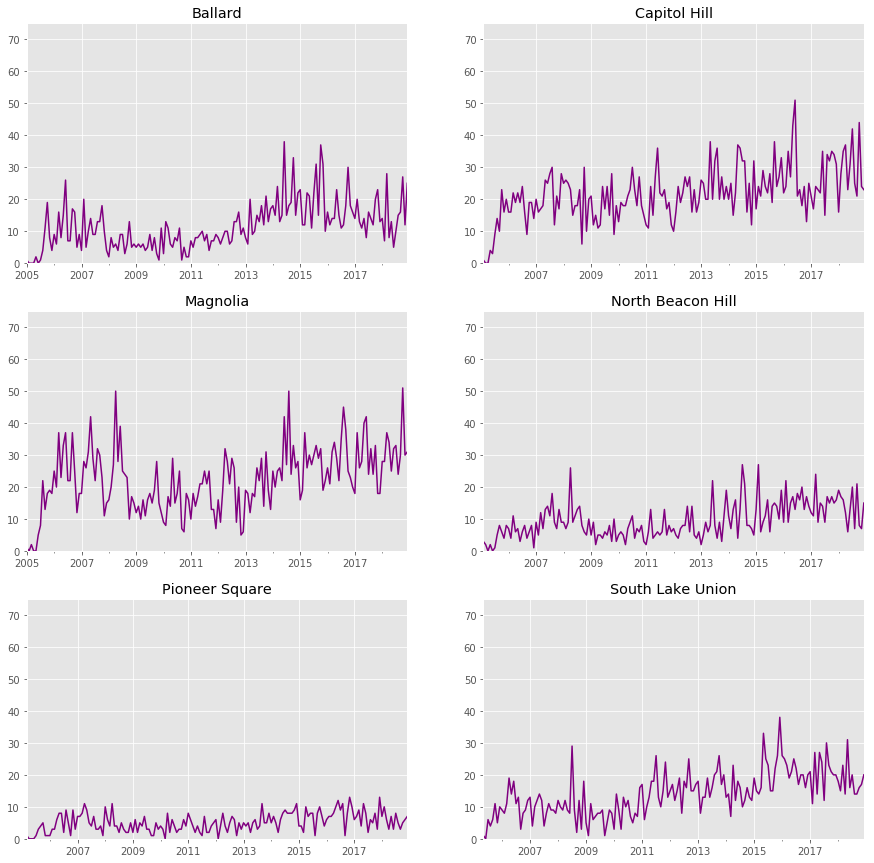

In [75]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('ggplot')

ncols=2
nrows=3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))

for (name, neighborhood_df), axis in zip(grouped.groupby(level=0), axes.flatten()):
    axis.xaxis.label.set_visible(False)
    axis.set_ylim(0, 75)
    axis.set_xlim(left=datetime.date(2000, 1, 1), right=datetime.date(2018, 12, 31))
    axis.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    neighborhood_df.xs(name).plot(title=name, style="", ax=axis, legend=False, color="purple")


What are your observations based on these plots?

## Understanding trend and seasonality

Let's select one of these neighboorhoods to drill in on. I'm partial to Ballard.

The statsmodels package in Python gives us a really useful set of tools for analyzing time series data. In particular, we can use the `seasonal_decompose` method to breakdown a time series into consituent series corresponding to the longterm trend in the data, the seasonal aspect of the data, and noise.

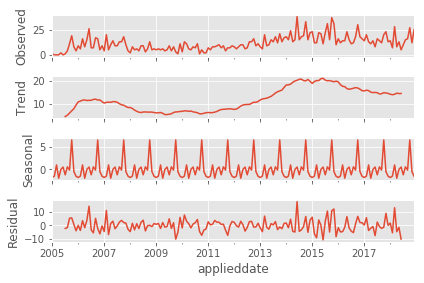

In [26]:
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

name, neighborhood_df = list(grouped.groupby(level=0))[0] # Ballard
result = seasonal_decompose(neighborhood_df.xs(name))
fig = result.plot()